# Example 11 - Horizontal Layers

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 7364 m wide (W-E extent) and 9176 m high (N-S extent). The model represents horizontally deposited layers. 
The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and will be used to calculate orientations for the `GemPy` model. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example11.png" width="800">

Map Source: An Introduction to Geological Structures and Maps by G.M. Bennison

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded form an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example11/'
gg.download_gemgis_data.download_tutorial_data(filename="example11_horizontal_layers.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example11.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo11.shp')
topo.head()

,id,Z,geometry
0,None,300,"LINESTRING (5554.550 9169.979, 5469.438 8954.3..."
1,None,400,"LINESTRING (4595.623 9164.305, 4696.339 8940.1..."
2,None,700,"LINESTRING (6411.342 6429.379, 6524.824 6460.5..."
3,None,600,"LINESTRING (7360.338 6813.800, 7170.255 6803.8..."
4,None,500,"LINESTRING (6784.415 7146.446, 6510.639 7045.7..."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=15)

### Plotting the raster

Text(185.82372641509448, 0.5, 'Y [m]')

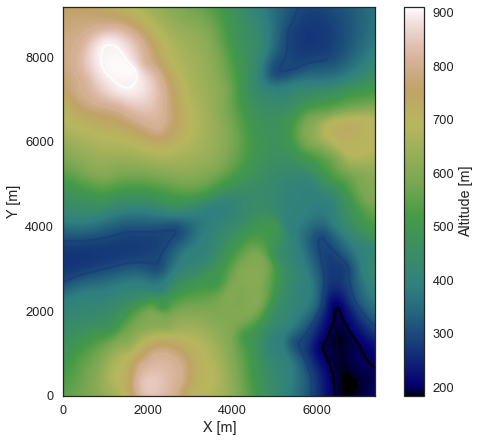

In [6]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1)
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0,7364,0,9176], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as as raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster11.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

<img src="../images/interfaces_example11.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces11.shp')
interfaces.head()

,id,formation,geometry
0,None,Limestone,"LINESTRING (993.266 8745.838, 1122.353 8748.67..."
1,None,Sandstone,"LINESTRING (1496.845 9169.979, 1676.998 9043.7..."
2,None,Claystone,"LINESTRING (4006.933 7206.733, 4012.608 7058.4..."
3,None,Schist,"LINESTRING (3809.049 9166.432, 3899.834 8898.3..."
4,None,Siltstone,"LINESTRING (8.807 3915.744, 258.468 3921.418, ..."


### Extracting Z coordinate from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords = interfaces_coords[interfaces_coords['formation'].isin(['Limestone', 'Sandstone', 'Claystone', 'Schist', 'Siltstone'])]
interfaces_coords

,formation,geometry,X,Y,Z
0,Limestone,POINT (993.266 8745.838),993.27,8745.84,800.72
1,Limestone,POINT (1122.353 8748.675),1122.35,8748.68,801.43
2,Limestone,POINT (1267.043 8743.001),1267.04,8743.00,800.10
3,Limestone,POINT (1398.966 8710.375),1398.97,8710.37,802.97
4,Limestone,POINT (1539.401 8647.960),1539.40,8647.96,802.86
...,...,...,...,...,...
215,Siltstone,POINT (2861.471 3478.836),2861.47,3478.84,364.48
216,Siltstone,POINT (2776.359 3405.073),2776.36,3405.07,363.79
217,Siltstone,POINT (2677.062 3300.101),2677.06,3300.10,357.72
218,Siltstone,POINT (2596.205 3209.316),2596.21,3209.32,351.91


### Plotting the Interface Points

Text(197.6315344467643, 0.5, 'Y [m]')

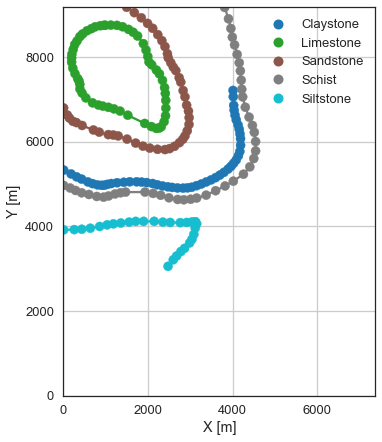

In [10]:
fig, ax = plt.subplots(1)

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlim(0,7364)
plt.ylim(0,9176)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Strike Lines

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 

For this example, the orientations were defined by points in QGIS as the layers were deposited horizontally and have no dip.

<img src="../images/orientations_example11.png" width="800">

In [11]:
orientations = gpd.read_file(file_path + 'orientations11.shp')
orientations = gg.vector.extract_xyz(gdf=orientations, dem=topo_raster)
orientations.head()

,dip,azimuth,polarity,formation,geometry,X,Y,Z
0,0.00,0.00,1.00,Limestone,POINT (1111.004 8516.036),1111.00,8516.04,867.24
1,0.00,0.00,1.00,Limestone,POINT (2041.560 6791.104),2041.56,6791.10,842.33
2,0.00,0.00,1.00,Limestone,POINT (747.861 7245.033),747.86,7245.03,837.07
3,0.00,0.00,1.00,Limestone,POINT (1791.899 7971.321),1791.90,7971.32,848.08
4,0.00,0.00,1.00,Sandstone,POINT (2540.883 6223.692),2540.88,6223.69,755.14


### Plotting the Orientations

Text(192.2670939457202, 0.5, 'Y [m]')

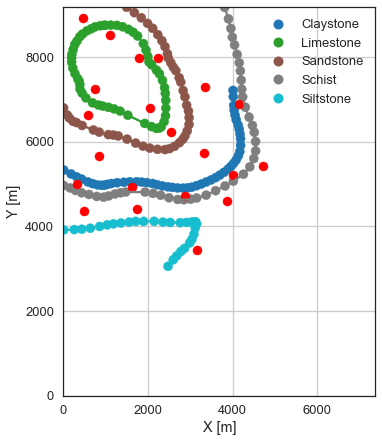

In [12]:
fig, ax = plt.subplots(1)

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlim(0,7364)
plt.ylim(0,9176)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [13]:
import gempy as gp

### Creating new Model

In [14]:
geo_model = gp.create_model('Model11')
geo_model

Model11  2021-03-30 10:10

### Initiate Data

In [15]:
gp.init_data(geo_model, [0,7364,0,9176,0,1000], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model11  2021-03-30 10:10

### Model Surfaces

In [16]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Limestone,Default series,1,#015482,1
1,Sandstone,Default series,2,#9f0052,2
2,Claystone,Default series,3,#ffbe00,3
3,Schist,Default series,4,#728f02,4
4,Siltstone,Default series,5,#443988,5


### Mapping the Stack to Surfaces

In [17]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Strata1': ('Limestone', 'Sandstone', 'Claystone', 'Schist', 'Siltstone'),
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')

,surface,series,order_surfaces,color,id
0,Limestone,Strata1,1,#015482,1
1,Sandstone,Strata1,2,#9f0052,2
2,Claystone,Strata1,3,#ffbe00,3
3,Schist,Strata1,4,#728f02,4
4,Siltstone,Strata1,5,#443988,5
5,Basement,Strata1,6,#ff3f20,6


### Showing the Number of Data Points

In [18]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,Limestone,Strata1,1,#015482,1,54,4
1,Sandstone,Strata1,2,#9f0052,2,44,4
2,Claystone,Strata1,3,#ffbe00,3,50,3
3,Schist,Strata1,4,#728f02,4,43,5
4,Siltstone,Strata1,5,#443988,5,29,5
5,Basement,Strata1,6,#ff3f20,6,0,0


### Loading Digital Elevation Model

In [19]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster11.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[3.68200000e+01, 4.58800000e+01, 5.00000000e+00],
       [3.68200000e+01, 4.58800000e+01, 1.50000000e+01],
       [3.68200000e+01, 4.58800000e+01, 2.50000000e+01],
       ...,
       [7.35650102e+03, 9.13851634e+03, 3.66282013e+02],
       [7.35650102e+03, 9.15350980e+03, 3.66405060e+02],
       [7.35650102e+03, 9.16850327e+03, 3.66539032e+02]])

### Defining Custom Section

In [20]:
custom_section = gpd.read_file(file_path + 'customsection11.shp')
custom_section_dict = gg.utils.to_section_dict(custom_section, section_column='name')
geo_model.set_section_grid(custom_section_dict)

Active grids: ['regular' 'topography' 'sections']


,start,stop,resolution,dist
Section1,"[2033.048983708095, 9169.978630835749]","[2008.9339736694492, 4.856286148714844]","[100, 80]",9165.15


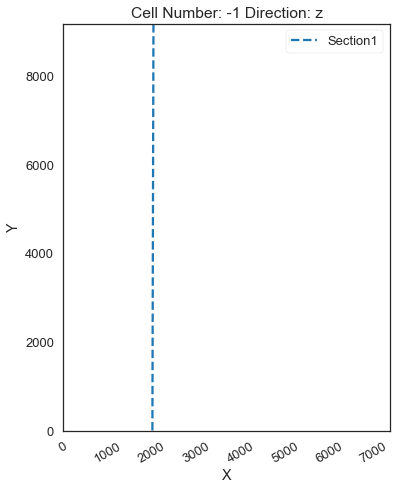

In [21]:
gp.plot.plot_section_traces(geo_model)

### Plotting Input Data

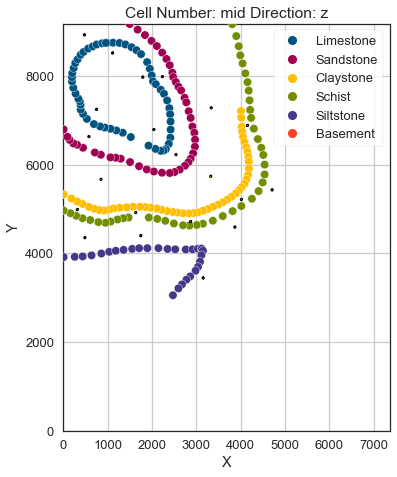

In [22]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

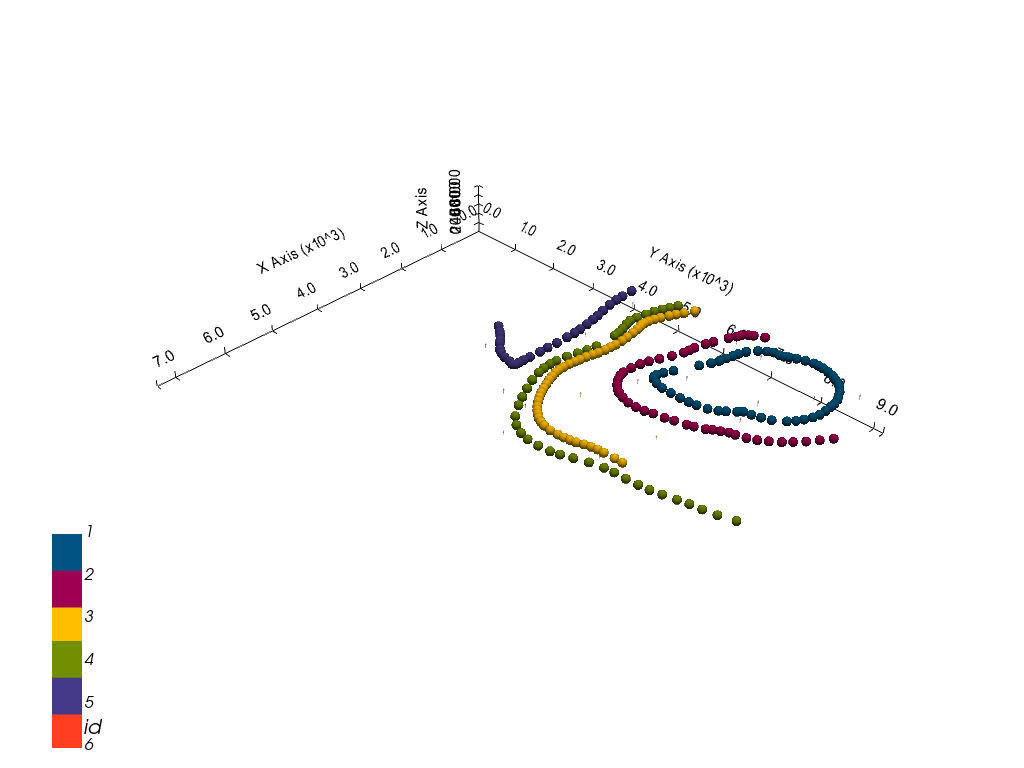

In [23]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [24]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range             11807.94
$C_o$           3319701.71
drift equations        [3]


### Computing Model

In [25]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

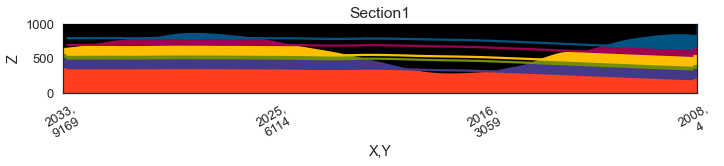

In [26]:
gp.plot_2d(geo_model, section_names=['Section1'], show_topography=True, show_data=False)

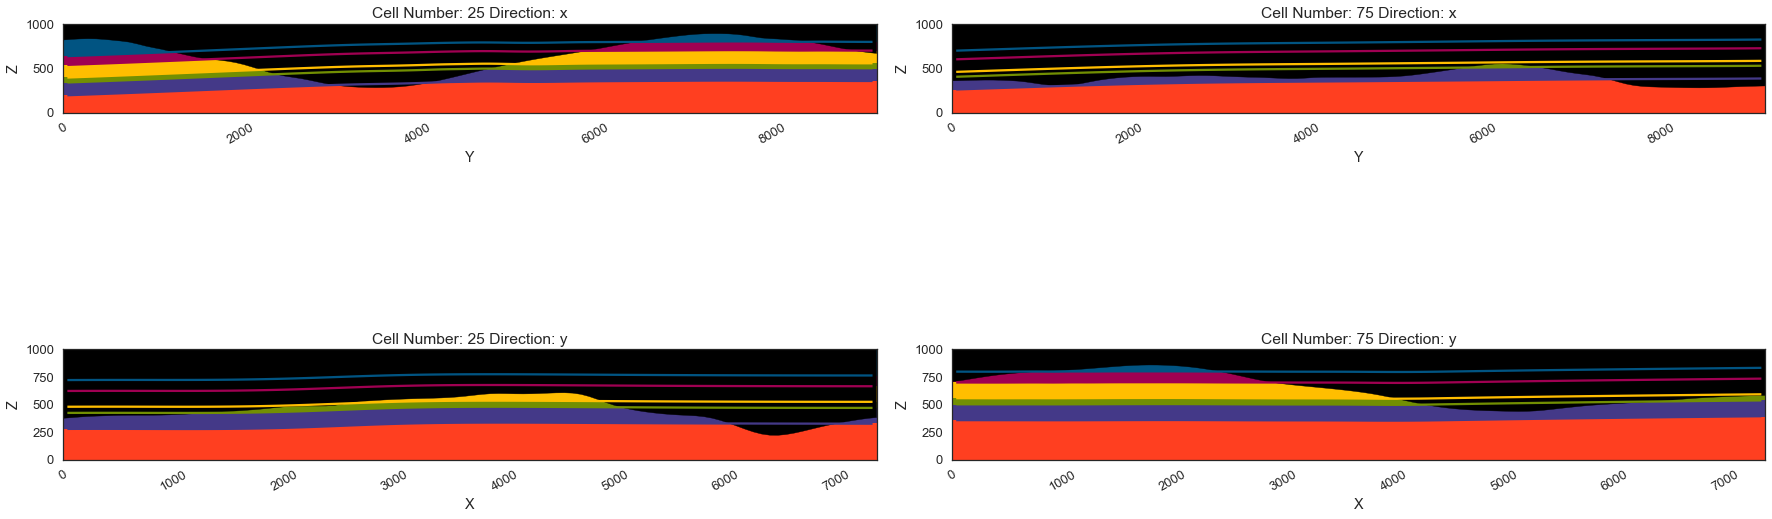

In [27]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

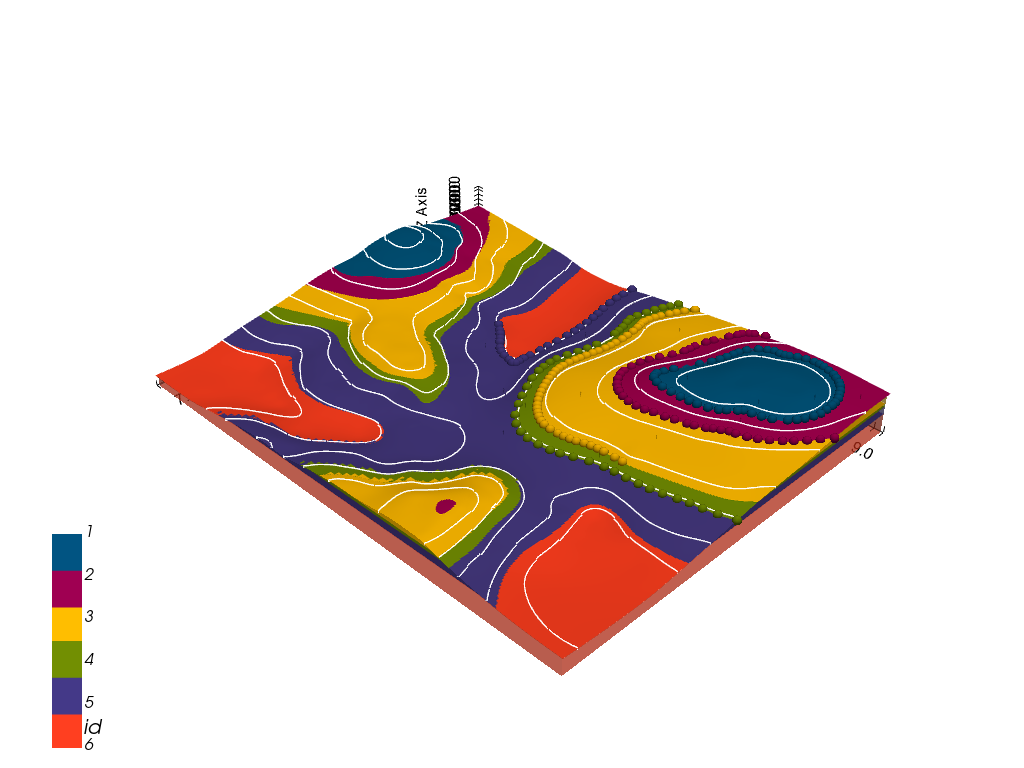

In [28]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)